
## Model Selection
How do we know we have a good model? How do we know that the machine learning algorithm is "good"?

We can perform a K-fold cross-validaion on the data: 
* holding out 1/K of the data for testing, 
* training on the reamining data, 
* repeating this K times, one for each fold
* averaging the resulting accuracy/score of the model

In [1]:
# Pandas, Numpy
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Libraries for Processing Network Traffic
import ipaddress
import netaddr

# Allow us to load modules from the parent directory
import sys
sys.path.append("../lib") 
from parse_pcap import pcap_to_pandas

## Hyperparameter Tuning

Most machine learning models have parameters associated with them.  Below we can explore how to tune these hyperparameters using a technique called grid search. Grid search usually involves searching over ranges of multiple parameters, but can also involve searching over values for a single parameter.

In the case of a linear regression, there are specific parameters to control the complexity of the model. Both Lasso and Ridge Regression, for example, have an alpha parameter that penalizes non-zero coefficients: the larger the value of alpha, the less complex the model will be (i.e., the fewer non-zero coefficients there will be), and the less variance the model will have (i.e., it will be less likely to be overfit.

In the case of logistic regression, there is a regularization called 'C' that controls overfitting.  You can explore different values of 'C'.  

### Logistic Regression

In [2]:
pcap = pcap_to_pandas('../pcaps/google_home.pcap') # this can take a few minutes
regr = LogisticRegression(solver='lbfgs', C=1)

dns_packets = pcap.loc[pcap['is_dns'] == True];
dns_ft = dns_packets.loc[:,['length','dns_resp']]
dns_ft['response'] = dns_ft['dns_resp'].astype(bool)
dns_ft['response'] = dns_ft['response'].astype(int)

x = dns_ft['length'].values
y = dns_ft['response'].values

In [3]:
regr = LogisticRegression(solver='lbfgs', C=0.1)
regr.fit(x.reshape(-1,1),y)

LogisticRegression(C=0.1)

### Grid Search

In [4]:
from sklearn.model_selection import GridSearchCV

k = 5

# Set the grid search parameters.
# Here there is only one value we are testing, C.
C_range = np.arange(1,5,1)
params = {
    'C': C_range,
}

grid_model = GridSearchCV(estimator=regr,
                          param_grid=params,
                          cv=k,
                          return_train_score=True,
                          scoring='accuracy'                        )

# Return the best fit model
gregr = grid_model.fit(x.reshape(-1,1),y)

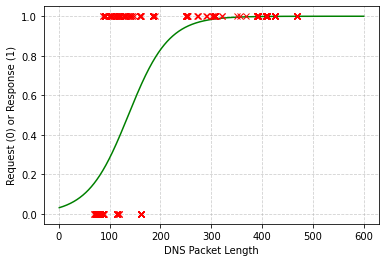

In [5]:
# Plot data
# z is a simple number line 1 to 600
z = np.arange(1, 600, 0.5).reshape(-1, 1);

# prediction: plot the number line against the predictions for those values
plt.plot(z, gregr.predict_proba(z)[:, 1], color='green');
plt.plot(x,y, 'x', color='red')
plt.ylabel("Request (0) or Response (1)")
plt.xlabel("DNS Packet Length")
plt.grid(linestyle='--', alpha=0.6)
plt.show()

## Evaluation

### Splitting Training and Testing

You do not want to evaluate your trained model on the training data. Rather, you must evaluate the model on test data that the model has never seen before. One approach to doing so is performing what is called a train-test split, whereby some fraction of the data is held out as a test set. The `train_test_split` function will perform this function for you.

Below shows an example evaluation on the test data, using both a confusion matrix and standard evaluation metrics.

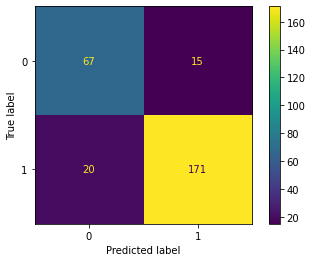

In [6]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

# perform the train test split
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

plot_confusion_matrix(gregr,X_test.reshape(-1,1),y_test)
plt.show()

### Cross Validation

Another common method for evaluating a model is using a technique called cross validation. The basic idea is to perform a series of evaluations with different train-test splits and then average the results. One common way of performing cross validation is called "k-fold cross validation", whereby each iteration uses one portion or "fold" of the data for training and the rest for testing, and subsequently holds out different folds.

In [7]:
from sklearn.model_selection import KFold, cross_val_score

# K-fold Cross Validation
kf = KFold(n_splits=5)

cv_results = cross_val_score(regr,
                             x.reshape(-1,1),
                             y,
                             cv=kf,
                             scoring="accuracy")
cv_results.mean()

0.8589231846584788